# Импорт библиотек

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 200)
#messages = pd.read_csv('news.csv')
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing 
from sklearn.neighbors import KNeighborsClassifier
import mlxtend
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import numpy as np   
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn import preprocessing
import seaborn as sns
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit
from sklearn.dummy import DummyClassifier

In [2]:
res = pd.read_csv('result_1.csv')
res_1 = pd.read_csv('result_2.csv')
res = res.drop(labels=['raw_news'], axis=1)
stop_words = nltk.corpus.stopwords.words('russian')
from sklearn.metrics import precision_recall_fscore_support, f1_score

In [3]:
res['has news'] = res['message'].notna()

In [4]:
num_of_news = pd.DataFrame(res[['<TICKER>', 'has news']].groupby(['<TICKER>'])['has news'].sum())

# Функции

In [5]:
def create_features(df, label=None):
    df['date'] = df.index
    df['minutes'] = df['date'].dt.minute
    df['hour'] = df['date'].dt.hour
    df['day'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    #df['movingavg4weeks'] = round(df['<CLOSE>'].rolling(window=(4*5), min_periods = 1).mean().shift(),2)
    #df['movingavg16weeks'] = round(df['<CLOSE>'].rolling(window=(16*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 4 weeks 
    #df['movingavg28weeks'] = round(df['<CLOSE>'].rolling(window=(28*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 16 weeks
    #df['movingavg40weeks'] = round(df['<CLOSE>'].rolling(window=(40*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 28 weeks
    #df['movingavg52weeks'] = round(df['<CLOSE>'].rolling(window=(52*5), min_periods = 1).mean().shift(),2)  #add 12 weeks to 40 weeks
    #df['window10days'] = round(df['<CLOSE>'].rolling(window = 10, min_periods = 1).mean().shift(),2)  
    #df['window50days'] = round(df['<CLOSE>'].rolling(window = 50, min_periods = 1).mean().shift(),2)
    df['delta'] = (df['<CLOSE>']+df['<OPEN>']+df['<HIGH>']+df['<LOW>'])/4 - (df['<CLOSE>'].shift(1)
                                                                            +df['<OPEN>'].shift(1)
                                                                            +df['<HIGH>'].shift(1)
                                                                            +df['<LOW>'].shift(1))


# Цикл метрик для топ 5 компаний  через 10 минут прогнала)

In [6]:
ticker_list = ['GOOG-RM','FIVE','SBER','RBCM','MGNT','YNDX','AFLT','GMKN',
               'GAZP','MAIL','MTSS','RUAL','TCSG','ROSN','FB-RM','LKOH','AAPL-RM','VTBR']
company = []
period = []
train = []
test = []
model = []
f1 = []
accuracy = []

In [7]:
def scores(how):
    for ticker in ticker_list: 
        YNDX = res[res['<TICKER>'] == ticker]
        YNDX = YNDX[['<TICKER>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date', 'y_3', 'y_7','y_11',
                     'y_14', 'y_17', 'y_20', 'lem_message', 'message']]
        YNDX = YNDX.groupby(['<TICKER>','<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date', 'y_3', 'y_7',
                             'y_11', 'y_14', 'y_17','y_20', 
                             'message'])['lem_message'].apply(lambda x: ', '.join(x.astype(str))).reset_index()
        YNDX.sort_values(by = 'date', axis=0, ascending=True, inplace=True)
        YNDX = YNDX.set_index(pd.DatetimeIndex(YNDX['date']))
        create_features(YNDX)
        #pd.get_dummies(YNDX, columns=['<TICKER>'])
        YNDX = YNDX.drop(labels=['date'], axis=1)
        YNDX = YNDX.dropna()
        Y_3 = YNDX['y_3']
        Y_7 = YNDX['y_7']
        Y_11 = YNDX['y_11']
        Y_14 = YNDX['y_14']
        Y_17 = YNDX['y_17']
        Y_20 = YNDX['y_20']
        
        YNDX = YNDX.drop(labels=['<TICKER>', 'y_3', 'y_7','y_11', 'y_14', 'y_17', 'y_20', 'message'], axis=1)
        X = YNDX
        tscv = TimeSeriesSplit()
        print('Обучается '+ticker)
        for train_index, test_index in tscv.split(X):
            split_1 = train_index[-1]+1
            split_2 = test_index[-1]+1
            X_train, X_test = YNDX.iloc[:split_1, :], YNDX.iloc[split_1:split_2, :]
            y_train_3, y_test_3 = Y_3.iloc[:split_1], Y_3.iloc[split_1:split_2]
            y_train_7, y_test_7 = Y_7.iloc[:split_1], Y_7.iloc[split_1:split_2]

            y_train_11, y_test_11 = Y_11.iloc[:split_1], Y_11.iloc[split_1:split_2]
            y_train_14, y_test_14 = Y_14.iloc[:split_1], Y_14.iloc[split_1:split_2]
            y_train_17, y_test_17 = Y_17.iloc[:split_1], Y_17.iloc[split_1:split_2]
            y_train_20, y_test_20 = Y_20.iloc[:split_1], Y_20.iloc[split_1:split_2]

            res_1 = res.dropna()

            # train

            tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                                    ngram_range=(1,2), 
                                    stop_words=stop_words, max_features=6000)

            tfidf.fit(res_1['lem_message'])
            features_train = tfidf.transform(X_train['lem_message'])

            # test

            tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                                    ngram_range=(1,2), 
                                    stop_words=stop_words, max_features=6000)
            tfidf.fit(res_1['lem_message'])
            features_test = tfidf.transform(X_test['lem_message'])
            features_train = tfidf.transform(X_train['lem_message'])
            X_train = X_train.drop(labels=['lem_message'], axis=1)
            X_test = X_test.drop(labels=['lem_message'], axis=1)

            df_train, df_test = features_train.todense(), features_test.todense()

            X_data_train, X_data_test = df_train, df_test

            #print(X_data_train.shape, ' ',X_data_test.shape)
            #print('Обучается '+ticker)

            X_tr = np.array(X_data_train)
            y_tr_3 = np.array(y_train_3)
            y_tr_7 = np.array(y_train_7)
            y_tr_11 = np.array(y_train_11)
            y_tr_14 = np.array(y_train_14)
            y_tr_17 = np.array(y_train_17)
            y_tr_20 = np.array(y_train_20)

            clf1 = LogisticRegression(random_state=1,
                                      solver='newton-cg',
                                      multi_class='ovr')
            clf2 = RidgeClassifier()
            clf3 = SVC()
            clf4 = RandomForestClassifier()
            clf5 = AdaBoostClassifier()
            clf6 = DummyClassifier(strategy = 'uniform')
            labels = ['Logistic Regression', 'Ridge', 'SVM', 'Random Forest', 'AdaBoost', 'Rand']

            if how == 'report':


                models = [clf1, clf2, clf3, clf4, clf5, clf6]
                print('------------------------'+'10 min'+'------------------------')
                for clf, lab in zip(models, labels):
                    clf.fit(X_data_train, y_train_3)
                    print('------------------------'+ticker+'------------------------')
                    print('------------------------'+lab+'------------------------')
                    y_test_pred = clf.predict(X_data_test)
                    arg_test = {'y_true':y_test_3, 'y_pred':y_test_pred}
                    print(confusion_matrix(**arg_test))
                    print(classification_report(**arg_test))

                models = [clf1, clf2, clf3, clf4, clf5, clf6]
                print('------------------------'+'20 min'+'------------------------')
                for clf, lab in zip(models, labels):
                    clf.fit(X_data_train, y_train_7)
                    print('------------------------'+ticker+'------------------------')
                    print('------------------------'+lab+'------------------------')
                    y_test_pred = clf.predict(X_data_test)
                    arg_test = {'y_true':y_test_7, 'y_pred':y_test_pred}
                    print(confusion_matrix(**arg_test))
                    print(classification_report(**arg_test))

            elif how == 'table':

                # делаем таблицу
                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('10 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_3).predict(X_data_test)
                    test.append(np.mean(y_test_3==y_predicted_test))
                    f1.append(f1_score(y_test_3, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_3, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_3).predict(X_data_train)
                    train.append(np.mean(y_train_3==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('20 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_7).predict(X_data_test)
                    test.append(np.mean(y_test_7==y_predicted_test))
                    f1.append(f1_score(y_test_7, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_7, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_7).predict(X_data_train)
                    train.append(np.mean(y_train_7==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('30 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_11).predict(X_data_test)
                    test.append(np.mean(y_test_11==y_predicted_test))
                    f1.append(f1_score(y_test_11, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_11, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_11).predict(X_data_train)
                    train.append(np.mean(y_train_11==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('40 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_14).predict(X_data_test)
                    test.append(np.mean(y_test_14==y_predicted_test))
                    f1.append(f1_score(y_test_14, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_14, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_14).predict(X_data_train)
                    train.append(np.mean(y_train_14==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('50 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_17).predict(X_data_test)
                    test.append(np.mean(y_test_17==y_predicted_test))
                    f1.append(f1_score(y_test_17, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_17, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_17).predict(X_data_train)
                    train.append(np.mean(y_train_17==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('60 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_20).predict(X_data_test)
                    test.append(np.mean(y_test_20==y_predicted_test))
                    f1.append(f1_score(y_test_20, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_20, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_20).predict(X_data_train)
                    train.append(np.mean(y_train_20==y_predicted_train))

        tab = {'f1_score':f1, 'company': company, 'period': period,'model': model, 'Train': train , 'Test': test,
                  'accuracy': accuracy}
        tabl = pd.DataFrame(tab, columns = ['company', 'period', 'model','Train', 'Test', 'f1_score', 'accuracy'])
    if how == 'table':
        return tabl

In [8]:
report = scores('table')

Обучается GOOG-RM
Обучается FIVE
Обучается SBER
Обучается RBCM
Обучается MGNT
Обучается YNDX
Обучается AFLT
Обучается GMKN
Обучается GAZP
Обучается MAIL
Обучается MTSS
Обучается RUAL
Обучается TCSG
Обучается ROSN
Обучается FB-RM
Обучается LKOH
Обучается AAPL-RM
Обучается VTBR


In [9]:
report = report.merge(num_of_news, right_on = '<TICKER>', left_on = 'company')

In [10]:
company = []
period = []
train = []
test = []
model = []
f1 = []
accuracy = []

In [11]:
def scores_without_texts(how):

    for ticker in ticker_list: 
        YNDX = res[res['<TICKER>'] == ticker]
        YNDX = YNDX[['<TICKER>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date', 'y_3', 'y_7','y_11', 'y_14',
                     'y_17', 'y_20', 'lem_message', 'message']]
        YNDX = YNDX.groupby(['<TICKER>','<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date',
                             'y_3', 'y_7','y_11', 'y_14',
                             'y_17', 'y_20', 'message'])['lem_message'].apply(lambda x: ', '.join(x.astype(str))).reset_index()
        YNDX.sort_values(by = 'date', axis=0, ascending=True, inplace=True)
        YNDX = YNDX.set_index(pd.DatetimeIndex(YNDX['date']))
        create_features(YNDX)
        #pd.get_dummies(YNDX, columns=['<TICKER>'])
        YNDX = YNDX.drop(labels=['date'], axis=1)
        YNDX = YNDX.dropna()
        Y_3 = YNDX['y_3']
        Y_7 = YNDX['y_7']
        Y_11 = YNDX['y_11']
        Y_14 = YNDX['y_14']
        Y_17 = YNDX['y_17']
        Y_20 = YNDX['y_20']
        YNDX = YNDX.drop(labels=['<TICKER>', 'y_3', 'y_7','y_11', 'y_14', 'y_17', 'y_20','message', 'lem_message'], axis=1)
        X = YNDX
        
        tscv = TimeSeriesSplit()
        print('Обучается '+ticker)
        
        for train_index, test_index in tscv.split(X):
            split_1 = train_index[-1]+1
            split_2 = test_index[-1]+1
            X_train, X_test = YNDX.iloc[:split_1, :], YNDX.iloc[split_1:split_2, :]
            y_train_3, y_test_3 = Y_3.iloc[:split_1], Y_3.iloc[split_1:split_2]
            y_train_7, y_test_7 = Y_7.iloc[:split_1], Y_7.iloc[split_1:split_2]

            y_train_11, y_test_11 = Y_11.iloc[:split_1], Y_11.iloc[split_1:split_2]
            y_train_14, y_test_14 = Y_14.iloc[:split_1], Y_14.iloc[split_1:split_2]
            y_train_17, y_test_17 = Y_17.iloc[:split_1], Y_17.iloc[split_1:split_2]
            y_train_20, y_test_20 = Y_20.iloc[:split_1], Y_20.iloc[split_1:split_2]

        # train

            normalizer = preprocessing.StandardScaler()
            train_norm = normalizer.fit_transform(X_train)
            train_transformed = pd.DataFrame(data=train_norm, columns = X_train.columns)

            normalizer = preprocessing.StandardScaler()
            test_norm = normalizer.fit_transform(X_test)
            test_transformed = pd.DataFrame(data=test_norm, columns = X_test.columns)


            X_data_train, X_data_test = X_train, X_test

            #print(X_data_train.shape, ' ',X_data_test.shape)


            X_tr = np.array(X_data_train)
            y_tr_3 = np.array(y_train_3)
            y_tr_7 = np.array(y_train_7)

            clf1 = LogisticRegression(random_state=1,
                                      solver='newton-cg',
                                      multi_class='ovr')
            clf2 = RidgeClassifier()
            clf3 = SVC()
            clf4 = RandomForestClassifier()
            clf5 = AdaBoostClassifier()
            clf6 = DummyClassifier(strategy = 'uniform')
            labels = ['Logistic Regression', 'Ridge', 'SVM', 'Random Forest', 'AdaBoost', 'Rand']


            if how == 'report':


                models = [clf1, clf2, clf3, clf4, clf5]
                print('------------------------'+'10 mins'+'------------------------')
                for clf, lab in zip(models, labels):
                    clf.fit(X_data_train, y_train_3)
                    print('------------------------'+ticker+'------------------------')
                    print('------------------------'+lab+'------------------------')
                    y_test_pred = clf.predict(X_data_test)
                    arg_test = {'y_true':y_test_3, 'y_pred':y_test_pred}
                    print(confusion_matrix(**arg_test))
                    print(classification_report(**arg_test))

                models = [clf1, clf2, clf3, clf4, clf5]
                print('------------------------'+'60 mins'+'------------------------')
                for clf, lab in zip(models, labels):
                    clf.fit(X_data_train, y_train_7)
                    print('------------------------'+ticker+'------------------------')
                    print('------------------------'+lab+'------------------------')
                    y_test_pred = clf.predict(X_data_test)
                    arg_test = {'y_true':y_test_7, 'y_pred':y_test_pred}
                    print(confusion_matrix(**arg_test))
                    print(classification_report(**arg_test))

            elif how == 'table':

                
                # делаем таблицу
                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('10 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_3).predict(X_data_test)
                    test.append(np.mean(y_test_3==y_predicted_test))
                    f1.append(f1_score(y_test_3, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_3, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_3).predict(X_data_train)
                    train.append(np.mean(y_train_3==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('20 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_7).predict(X_data_test)
                    test.append(np.mean(y_test_7==y_predicted_test))
                    f1.append(f1_score(y_test_7, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_7, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_7).predict(X_data_train)
                    train.append(np.mean(y_train_7==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('30 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_11).predict(X_data_test)
                    test.append(np.mean(y_test_11==y_predicted_test))
                    f1.append(f1_score(y_test_11, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_11, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_11).predict(X_data_train)
                    train.append(np.mean(y_train_11==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('40 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_14).predict(X_data_test)
                    test.append(np.mean(y_test_14==y_predicted_test))
                    f1.append(f1_score(y_test_14, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_14, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_14).predict(X_data_train)
                    train.append(np.mean(y_train_14==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('50 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_17).predict(X_data_test)
                    test.append(np.mean(y_test_17==y_predicted_test))
                    f1.append(f1_score(y_test_17, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_17, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_17).predict(X_data_train)
                    train.append(np.mean(y_train_17==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('60 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_20).predict(X_data_test)
                    test.append(np.mean(y_test_20==y_predicted_test))
                    f1.append(f1_score(y_test_20, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_20, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_20).predict(X_data_train)
                    train.append(np.mean(y_train_20==y_predicted_train))

        tab = {'f1_score':f1, 'company': company, 'period': period,'model': model, 'Train': train , 'Test': test,
                  'accuracy': accuracy}
        tabl = pd.DataFrame(tab, columns = ['company', 'period', 'model','Train', 'Test', 'f1_score', 'accuracy'])

    if how == 'table':
        return tabl

In [12]:
report_1 = scores_without_texts(how = 'table')

Обучается GOOG-RM
Обучается FIVE
Обучается SBER
Обучается RBCM
Обучается MGNT
Обучается YNDX
Обучается AFLT
Обучается GMKN
Обучается GAZP
Обучается MAIL
Обучается MTSS
Обучается RUAL
Обучается TCSG
Обучается ROSN
Обучается FB-RM
Обучается LKOH
Обучается AAPL-RM
Обучается VTBR


In [13]:
report_1 = report_1.merge(num_of_news, right_on = '<TICKER>', left_on = 'company')

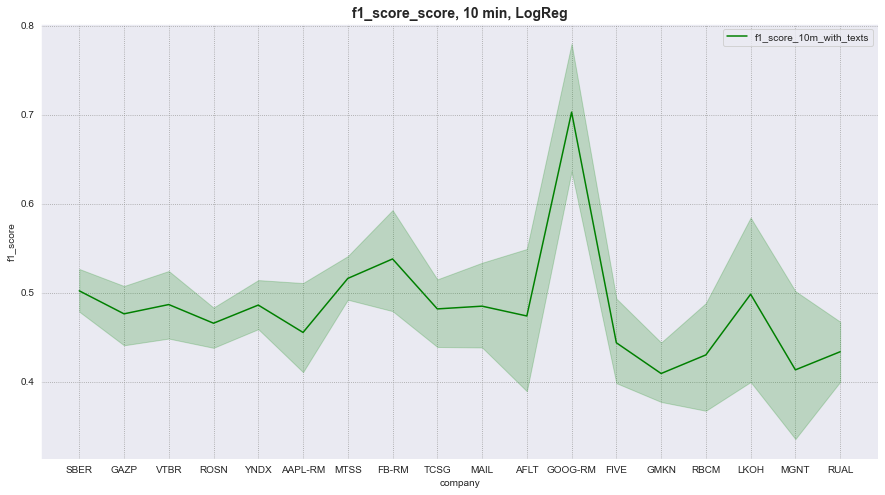

In [14]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score_score, 10 min, LogReg', weight='bold').set_fontsize('14')
metric = report[(report['period']=='10 min') & (report['model']=='Logistic Regression')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_10m_with_texts')
sns.lineplot(x=report_1[(report_1['period']=='10 mins') & (report_1['model']=='Logistic Regression')]['company'],
             y=report_1[(report_1['period']=='10 mins') & (report_1['model']=='Logistic Regression')]['f1_score'], color='red', label='f1_score_10m_without_texts')
plt.show()

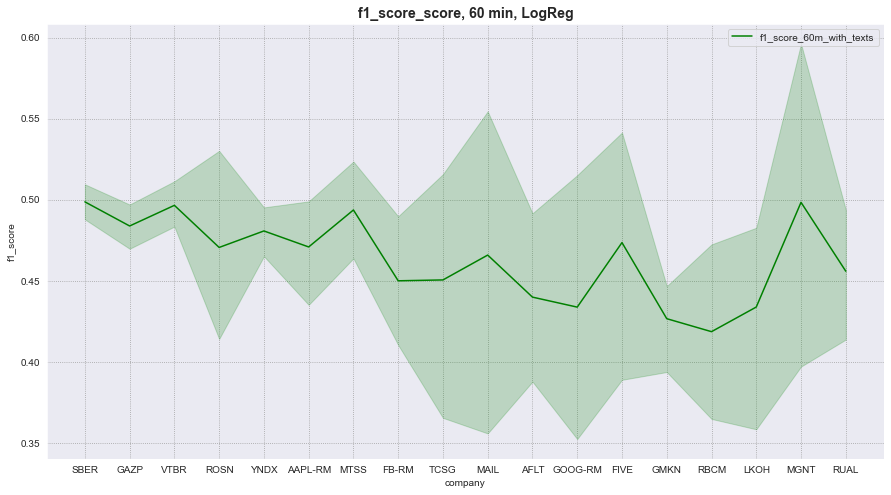

In [15]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score_score, 60 min, LogReg', weight='bold').set_fontsize('14')
metric = report[(report['period']=='60 min') & (report['model']=='Logistic Regression')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_60m_with_texts')
sns.lineplot(x=report_1[(report_1['period']=='60 mins') & (report_1['model']=='Logistic Regression')]['company'],
             y=report_1[(report_1['period']=='60 mins') & (report_1['model']=='Logistic Regression')]['f1_score'], color='red', label='f1_score_60m_without_texts')
plt.show()

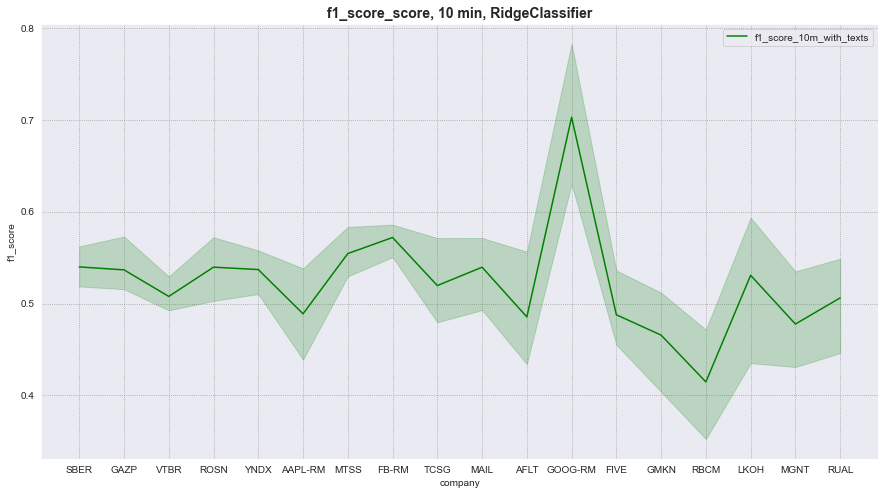

In [16]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score_score, 10 min, RidgeClassifier', weight='bold').set_fontsize('14')
metric = report[(report['period']=='10 min') & (report['model']=='Ridge')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_10m_with_texts')
sns.lineplot(x=report_1[(report_1['period']=='10 mins') & (report_1['model']=='Ridge')]['company'],
             y=report_1[(report_1['period']=='10 mins') & (report_1['model']=='Ridge')]['f1_score'], color='red', label='f1_score_10m_without_texts')
plt.show()

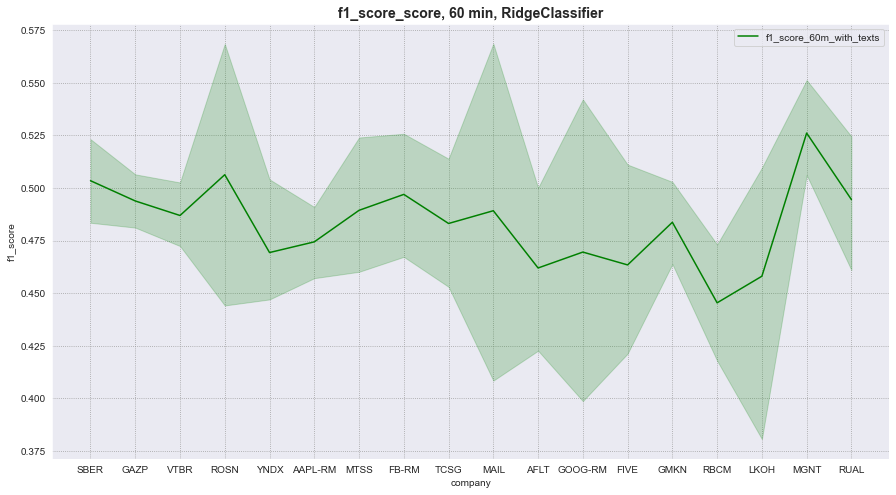

In [17]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score_score, 60 min, RidgeClassifier', weight='bold').set_fontsize('14')
metric = report[(report['period']=='60 min') & (report['model']=='Ridge')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_60m_with_texts')
sns.lineplot(x=report_1[(report_1['period']=='60 mins') & (report_1['model']=='Ridge')]['company'],
             y=report_1[(report_1['period']=='60 mins') & (report_1['model']=='Ridge')]['f1_score'], color='red', label='f1_score_60m_witoput_texts')
plt.show()

In [18]:
f1_1 = pd.DataFrame(report[['company', 'period', 'model', 'accuracy', 'f1_score']]
                    .groupby(['period', 'model'])['accuracy', 'f1_score'].mean())
f1_1

accuracy  f1_score
period model                                  
10 min AdaBoost             0.547676  0.537480
       Logistic Regression  0.579121  0.483189
       Rand                 0.504771  0.510624
       Random Forest        0.575333  0.498570
       Ridge                0.563803  0.522570
       SVM                  0.582142  0.465679
20 min AdaBoost             0.511317  0.504250
       Logistic Regression  0.520154  0.480062
       Rand                 0.495225  0.496644
       Random Forest        0.517541  0.482831
       Ridge                0.517346  0.498105
       SVM                  0.523848  0.457786
30 min AdaBoost             0.506079  0.497417
       Logistic Regression  0.511500  0.470519
       Rand                 0.505663  0.506604
       Random Forest        0.510338  0.472379
       Ridge                0.512480  0.494058
       SVM                  0.515921  0.453559
40 min AdaBoost             0.512656  0.505117
       Logistic Regression  0.513278  0.474730
       Rand                 0.505319  0.505745
       Random Forest        0.520966  0.487801
       Ridge                0.512044  0.494033
       SVM                  0.511998  0.451218
50 min AdaBoost             0.506956  0.499006
       Logistic Regression  0.500597  0.463139
       Rand                 0.505913  0.506360
       Random Forest        0.510474  0.479867
       Ridge                0.505443  0.490633
       SVM                  0.508421  0.451786
60 min AdaBoost             0.498343  0.489277
       Logistic Regression  0.501454  0.463411
       Rand                 0.494180  0.495009
       Random Forest        0.508404  0.475334
       Ridge                0.497774  0.483087
       SVM                  0.499371  0.439115

In [19]:
f1_2 = pd.DataFrame(report_1[['company', 'period', 'model', 'accuracy', 'f1_score']]
                    .groupby(['period', 'model'])['accuracy', 'f1_score'].mean())
f1_2

accuracy  f1_score
period model                                  
10 min AdaBoost             0.526430  0.487086
       Logistic Regression  0.636677  0.605657
       Rand                 0.497502  0.503721
       Random Forest        0.519334  0.483571
       Ridge                0.631390  0.592582
       SVM                  0.588982  0.439215
20 min AdaBoost             0.507166  0.469207
       Logistic Regression  0.582872  0.554706
       Rand                 0.502518  0.504099
       Random Forest        0.509641  0.473440
       Ridge                0.582561  0.547498
       SVM                  0.512935  0.352798
30 min AdaBoost             0.511582  0.467092
       Logistic Regression  0.550139  0.518453
       Rand                 0.499361  0.500299
       Random Forest        0.502371  0.463034
       Ridge                0.543433  0.505893
       SVM                  0.517684  0.355744
40 min AdaBoost             0.496728  0.453508
       Logistic Regression  0.532868  0.504473
       Rand                 0.494765  0.495460
       Random Forest        0.494350  0.451487
       Ridge                0.531180  0.497156
       SVM                  0.514506  0.354300
50 min AdaBoost             0.502570  0.466104
       Logistic Regression  0.527612  0.494134
       Rand                 0.495930  0.496882
       Random Forest        0.499114  0.455624
       Ridge                0.527761  0.492818
       SVM                  0.511008  0.354576
60 min AdaBoost             0.507466  0.469017
       Logistic Regression  0.520946  0.482795
       Rand                 0.509540  0.510626
       Random Forest        0.499248  0.457096
       Ridge                0.518768  0.479422
       SVM                  0.512370  0.353546

# то же самое только без всего (не гнала)

In [ ]:
def create_features(df, label=None):
    #df['date'] = df.index
    #df['movingavg4weeks'] = round(df['<CLOSE>'].rolling(window=(4*5), min_periods = 1).mean().shift(),2)
    #df['movingavg16weeks'] = round(df['<CLOSE>'].rolling(window=(16*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 4 weeks 
    #df['movingavg28weeks'] = round(df['<CLOSE>'].rolling(window=(28*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 16 weeks
    #df['movingavg40weeks'] = round(df['<CLOSE>'].rolling(window=(40*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 28 weeks
    #df['movingavg52weeks'] = round(df['<CLOSE>'].rolling(window=(52*5), min_periods = 1).mean().shift(),2)  #add 12 weeks to 40 weeks
    #df['window10days'] = round(df['<CLOSE>'].rolling(window = 10, min_periods = 1).mean().shift(),2)  
    #df['window50days'] = round(df['<CLOSE>'].rolling(window = 50, min_periods = 1).mean().shift(),2)
    df['delta'] = df['<CLOSE>'] - df['<CLOSE>'].shift(1)

In [ ]:
ticker_list = ['GOOG-RM','FIVE','SBER','RBCM','MGNT','YNDX','AFLT','GMKN',
               'GAZP','MAIL','MTSS','RUAL','TCSG','ROSN','FB-RM','LKOH','AAPL-RM','VTBR']
company = []
period = []
train = []
test = []
model = []
f1 = []
accuracy = []

In [22]:
def scores_1(how):
    for ticker in ticker_list: 
        YNDX = res[res['<TICKER>'] == ticker]
        YNDX = YNDX[['<TICKER>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date', 'y_3', 'y_7','y_11',
                     'y_14', 'y_17', 'y_20', 'lem_message', 'message']]
        YNDX = YNDX.groupby(['<TICKER>','<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date', 'y_3', 'y_7', 
                             'y_11', 'message'])['lem_message'].apply(lambda x: ', '.join(x.astype(str))).reset_index()
        YNDX.sort_values(by = 'date', axis=0, ascending=True, inplace=True)
        YNDX = YNDX.set_index(pd.DatetimeIndex(YNDX['date']))
        create_features(YNDX)
        #pd.get_dummies(YNDX, columns=['<TICKER>'])
        YNDX = YNDX.drop(labels=['date'], axis=1)
        YNDX = YNDX.dropna()
        Y_3 = YNDX['y_3']
        Y_7 = YNDX['y_7']
        Y_11 = YNDX['y_11']
        Y_14 = YNDX['y_14']
        Y_17 = YNDX['y_17']
        Y_20 = YNDX['y_20']
        YNDX = YNDX.drop(labels=['<TICKER>', 'y_3', 'y_7','y_11', 'y_14', 'y_17', 'y_20', '<OPEN>', '<HIGH>', '<LOW>',
                                 '<CLOSE>', 'message'], axis=1)
        X = YNDX
        tscv = TimeSeriesSplit()
        print('Обучается '+ticker)
        for train_index, test_index in tscv.split(X):
            split_1 = train_index[-1]+1
            split_2 = test_index[-1]+1
            X_train, X_test = YNDX.iloc[:split_1, :], YNDX.iloc[split_1:split_2, :]
            y_train_3, y_test_3 = Y_3.iloc[:split_1], Y_3.iloc[split_1:split_2]
            y_train_7, y_test_7 = Y_7.iloc[:split_1], Y_7.iloc[split_1:split_2]

            y_train_11, y_test_11 = Y_11.iloc[:split_1], Y_11.iloc[split_1:split_2]
            y_train_14, y_test_14 = Y_14.iloc[:split_1], Y_14.iloc[split_1:split_2]
            y_train_17, y_test_17 = Y_17.iloc[:split_1], Y_17.iloc[split_1:split_2]
            y_train_20, y_test_20 = Y_20.iloc[:split_1], Y_20.iloc[split_1:split_2]

            res_1 = res.dropna()

            # train

            tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                                    ngram_range=(1,2), 
                                    stop_words=stop_words, max_features=6000)

            tfidf.fit(res_1['lem_message'])
            features_train = tfidf.transform(X_train['lem_message'])

            # test

            tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                                    ngram_range=(1,2), 
                                    stop_words=stop_words, max_features=6000)
            tfidf.fit(res_1['lem_message'])
            features_test = tfidf.transform(X_test['lem_message'])
            features_train = tfidf.transform(X_train['lem_message'])
            X_train = X_train.drop(labels=['lem_message'], axis=1)
            X_test = X_test.drop(labels=['lem_message'], axis=1)

            df_train, df_test = features_train.todense(), features_test.todense()

            X_data_train, X_data_test = df_train, df_test

            #print(X_data_train.shape, ' ',X_data_test.shape)
            #print('Обучается '+ticker)

            X_tr = np.array(X_data_train)
            y_tr_3 = np.array(y_train_3)
            y_tr_7 = np.array(y_train_7)
            y_tr_11 = np.array(y_train_11)
            y_tr_14 = np.array(y_train_14)
            y_tr_17 = np.array(y_train_17)
            y_tr_20 = np.array(y_train_20)

            clf1 = LogisticRegression(random_state=1,
                                      solver='newton-cg',
                                      multi_class='ovr')
            clf2 = RidgeClassifier()
            clf3 = SVC()
            clf4 = RandomForestClassifier()
            clf5 = AdaBoostClassifier()
            clf6 = DummyClassifier(strategy = 'uniform')
            labels = ['Logistic Regression', 'Ridge', 'SVM', 'Random Forest', 'AdaBoost', 'Rand']

            if how == 'report':


                models = [clf1, clf2, clf3, clf4, clf5, clf6]
                print('------------------------'+'10 min'+'------------------------')
                for clf, lab in zip(models, labels):
                    clf.fit(X_data_train, y_train_3)
                    print('------------------------'+ticker+'------------------------')
                    print('------------------------'+lab+'------------------------')
                    y_test_pred = clf.predict(X_data_test)
                    arg_test = {'y_true':y_test_3, 'y_pred':y_test_pred}
                    print(confusion_matrix(**arg_test))
                    print(classification_report(**arg_test))

                models = [clf1, clf2, clf3, clf4, clf5, clf6]
                print('------------------------'+'20 min'+'------------------------')
                for clf, lab in zip(models, labels):
                    clf.fit(X_data_train, y_train_7)
                    print('------------------------'+ticker+'------------------------')
                    print('------------------------'+lab+'------------------------')
                    y_test_pred = clf.predict(X_data_test)
                    arg_test = {'y_true':y_test_7, 'y_pred':y_test_pred}
                    print(confusion_matrix(**arg_test))
                    print(classification_report(**arg_test))

            elif how == 'table':

                # делаем таблицу
                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('10 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_3).predict(X_data_test)
                    test.append(np.mean(y_test_3==y_predicted_test))
                    f1.append(f1_score(y_test_3, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_3, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_3).predict(X_data_train)
                    train.append(np.mean(y_train_3==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('20 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_7).predict(X_data_test)
                    test.append(np.mean(y_test_7==y_predicted_test))
                    f1.append(f1_score(y_test_7, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_7, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_7).predict(X_data_train)
                    train.append(np.mean(y_train_7==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('30 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_11).predict(X_data_test)
                    test.append(np.mean(y_test_11==y_predicted_test))
                    f1.append(f1_score(y_test_11, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_11, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_11).predict(X_data_train)
                    train.append(np.mean(y_train_11==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('40 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_14).predict(X_data_test)
                    test.append(np.mean(y_test_14==y_predicted_test))
                    f1.append(f1_score(y_test_14, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_14, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_14).predict(X_data_train)
                    train.append(np.mean(y_train_14==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('50 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_17).predict(X_data_test)
                    test.append(np.mean(y_test_17==y_predicted_test))
                    f1.append(f1_score(y_test_17, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_17, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_17).predict(X_data_train)
                    train.append(np.mean(y_train_17==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('60 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_20).predict(X_data_test)
                    test.append(np.mean(y_test_20==y_predicted_test))
                    f1.append(f1_score(y_test_20, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_20, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_20).predict(X_data_train)
                    train.append(np.mean(y_train_20==y_predicted_train))

        tab = {'f1_score':f1, 'company': company, 'period': period,'model': model, 'Train': train , 'Test': test,
                  'accuracy': accuracy}
        tabl = pd.DataFrame(tab, columns = ['company', 'period', 'model','Train', 'Test', 'f1_score', 'accuracy'])
    if how == 'table':
        return tabl

In [23]:
report_2 = scores_1('table')

Обучается GOOG-RM
Обучается FIVE
Обучается SBER
Обучается RBCM
Обучается MGNT
Обучается YNDX
Обучается AFLT
Обучается GMKN
Обучается GAZP
Обучается MAIL
Обучается MTSS
Обучается RUAL
Обучается TCSG
Обучается ROSN
Обучается FB-RM
Обучается LKOH
Обучается AAPL-RM
Обучается VTBR


In [24]:
report_2 = report_2.merge(num_of_news, right_on = '<TICKER>', left_on = 'company')

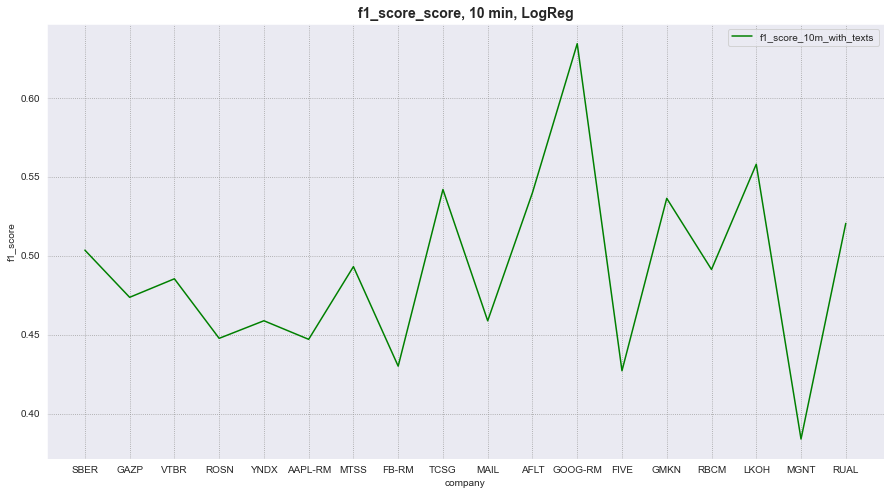

In [25]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score_score, 10 min, LogReg', weight='bold').set_fontsize('14')
metric = report_2[(report_2['period']=='10 min') & (report_2['model']=='Logistic Regression')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_10m_with_texts')

plt.show()

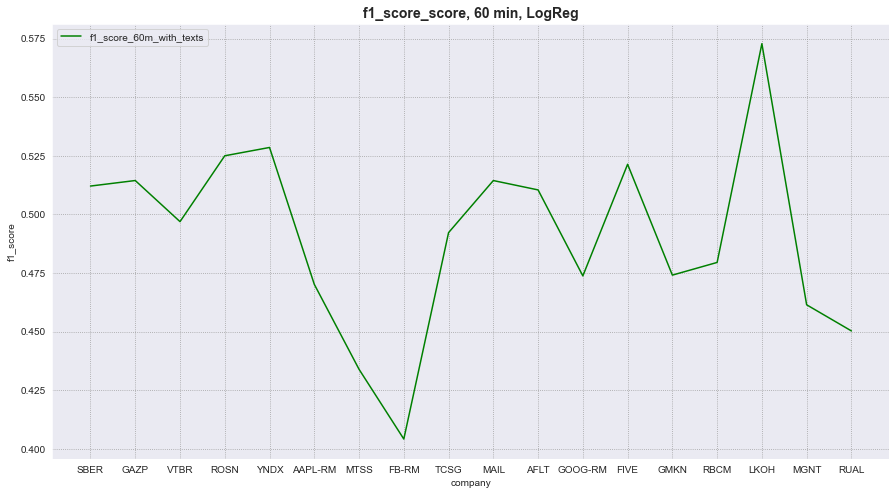

In [26]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score_score, 60 min, LogReg', weight='bold').set_fontsize('14')
metric = report_2[(report_2['period']=='60 min') & (report_2['model']=='Logistic Regression')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_60m_with_texts')

plt.show()

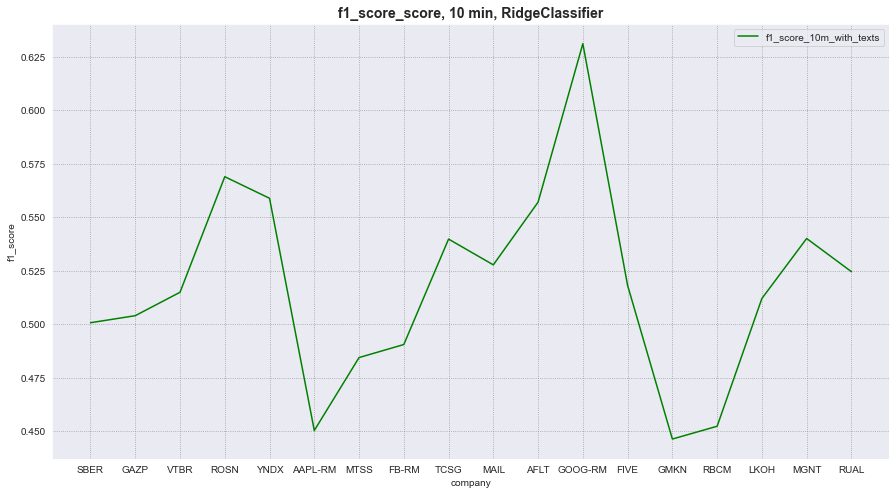

In [27]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score_score, 10 min, RidgeClassifier', weight='bold').set_fontsize('14')
metric = report_2[(report_2['period']=='10 min') & (report_2['model']=='RidgeClassifier')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_10m_with_texts')

plt.show()

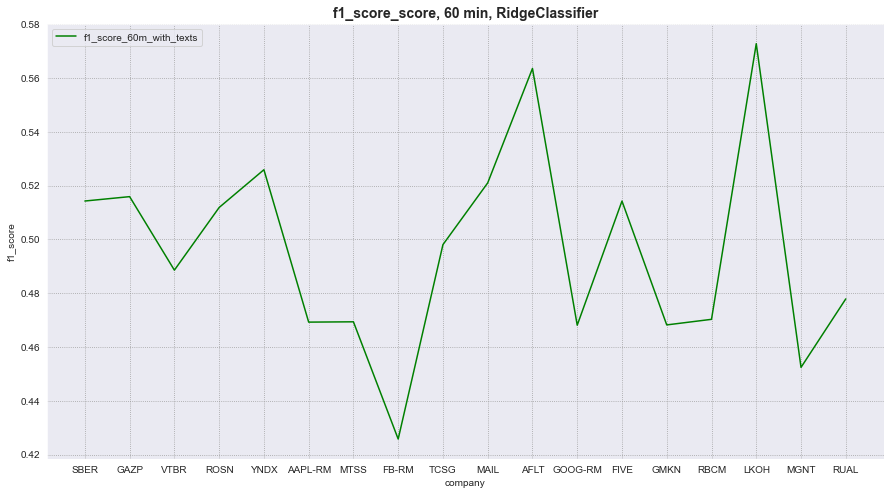

In [28]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score_score, 60 min, RidgeClassifier', weight='bold').set_fontsize('14')
metric = report_2[(report_2['period']=='60 min') & (report_2['model']=='RidgeClassifier')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_60m_with_texts')

plt.show()

In [29]:
f1_1 = pd.DataFrame(report_2[['company', 'period', 'model', 'f1_score', 'accuracy']]
                    .groupby(['period', 'model'])['f1_score', 'accuracy'].mean())
f1_1

f1_score
period model                        
10 min Boosting             0.542900
       Forest               0.521898
       Logistic Regression  0.490566
       RidgeClassifier      0.517921
       SVM                  0.452558
60 min Boosting             0.503857
       Forest               0.497930
       Logistic Regression  0.490857
       RidgeClassifier      0.495994
       SVM                  0.459224

In [40]:
pd.DataFrame(report_2[['company', 'period', 'model', 'accuracy']]
                    .groupby(['period', 'model'])['accuracy'].mean())

accuracy
period model                        
10 min Boosting             0.549943
       Forest               0.565574
       Logistic Regression  0.554524
       RidgeClassifier      0.539249
       SVM                  0.559990
60 min Boosting             0.510562
       Forest               0.515407
       Logistic Regression  0.508638
       RidgeClassifier      0.506635
       SVM                  0.519724

# без всего (прогнала)

In [20]:
company = []
period = []
train = []
test = []
model = []
f1 = []
accuracy = []

In [21]:
def scores_3(how):

    for ticker in ticker_list: 
        YNDX = res[res['<TICKER>'] == ticker]
        YNDX = YNDX[['y_3', 'y_7', 'y_11', 'y_14', 'y_17', 'y_20', 
                     'lem_message', 'message']]
        #YNDX = YNDX.groupby(['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date','y_3',
                             #'y_7', 'message'])['lem_message'].apply(lambda x: ', '.join(x.astype(str))).reset_index()
        #YNDX.sort_values(by = 'date', axis=0, ascending=True, inplace=True)
        #YNDX = YNDX.set_index(pd.DatetimeIndex(YNDX['date']))
        #create_features(YNDX)
        #pd.get_dummies(YNDX, columns=['<TICKER>'])
        YNDX = YNDX.dropna()
        Y_3 = YNDX['y_3']
        Y_7 = YNDX['y_7']
        Y_11 = YNDX['y_11']
        Y_14 = YNDX['y_14']
        Y_17 = YNDX['y_17']
        Y_20 = YNDX['y_20']
        YNDX = YNDX.drop(labels=['y_3', 'y_7','y_11', 'y_14', 'y_17', 'y_20','message'], axis=1)
        X = YNDX
        tscv = TimeSeriesSplit()
        print('Обучается '+ticker)
        for train_index, test_index in tscv.split(X):
            split_1 = train_index[-1]+1
            split_2 = test_index[-1]+1
            X_train, X_test = YNDX.iloc[:split_1, :], YNDX.iloc[split_1:split_2, :]
            y_train_3, y_test_3 = Y_3.iloc[:split_1], Y_3.iloc[split_1:split_2]
            y_train_7, y_test_7 = Y_7.iloc[:split_1], Y_7.iloc[split_1:split_2]

            y_train_11, y_test_11 = Y_11.iloc[:split_1], Y_11.iloc[split_1:split_2]
            y_train_14, y_test_14 = Y_14.iloc[:split_1], Y_14.iloc[split_1:split_2]
            y_train_17, y_test_17 = Y_17.iloc[:split_1], Y_17.iloc[split_1:split_2]
            y_train_20, y_test_20 = Y_20.iloc[:split_1], Y_20.iloc[split_1:split_2]

            res_1 = res.dropna()

            # train

            tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                                    ngram_range=(1,2), 
                                    stop_words=stop_words, max_features=6000)

            tfidf.fit(res_1['lem_message'])
            features_train = tfidf.transform(X_train['lem_message'])

            # test

            tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                                    ngram_range=(1,2), 
                                    stop_words=stop_words, max_features=6000)
            tfidf.fit(res_1['lem_message'])
            features_test = tfidf.transform(X_test['lem_message'])
            features_train = tfidf.transform(X_train['lem_message'])
            X_train = X_train.drop(labels=['lem_message'], axis=1)
            X_test = X_test.drop(labels=['lem_message'], axis=1)

            df_train, df_test = features_train.todense(), features_test.todense()

            X_data_train, X_data_test = df_train, df_test

            #print(X_data_train.shape, ' ',X_data_test.shape)
            #print('Обучается '+ticker)

            X_tr = np.array(X_data_train)
            y_tr_3 = np.array(y_train_3)
            y_tr_7 = np.array(y_train_7)
            y_tr_11 = np.array(y_train_11)
            y_tr_14 = np.array(y_train_14)
            y_tr_17 = np.array(y_train_17)
            y_tr_20 = np.array(y_train_20)

            clf1 = LogisticRegression(random_state=1,
                                      solver='newton-cg',
                                      multi_class='ovr')
            clf2 = RidgeClassifier()
            clf3 = SVC()
            clf4 = RandomForestClassifier()
            clf5 = AdaBoostClassifier()
            clf6 = DummyClassifier(strategy = 'uniform')
            labels = ['Logistic Regression', 'Ridge', 'SVM', 'Random Forest', 'AdaBoost', 'Rand']

            if how == 'report':


                models = [clf1, clf2, clf3, clf4, clf5, clf6]
                print('------------------------'+'10 min'+'------------------------')
                for clf, lab in zip(models, labels):
                    clf.fit(X_data_train, y_train_3)
                    print('------------------------'+ticker+'------------------------')
                    print('------------------------'+lab+'------------------------')
                    y_test_pred = clf.predict(X_data_test)
                    arg_test = {'y_true':y_test_3, 'y_pred':y_test_pred}
                    print(confusion_matrix(**arg_test))
                    print(classification_report(**arg_test))

                models = [clf1, clf2, clf3, clf4, clf5, clf6]
                print('------------------------'+'20 min'+'------------------------')
                for clf, lab in zip(models, labels):
                    clf.fit(X_data_train, y_train_7)
                    print('------------------------'+ticker+'------------------------')
                    print('------------------------'+lab+'------------------------')
                    y_test_pred = clf.predict(X_data_test)
                    arg_test = {'y_true':y_test_7, 'y_pred':y_test_pred}
                    print(confusion_matrix(**arg_test))
                    print(classification_report(**arg_test))

            elif how == 'table':

                # делаем таблицу
                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('10 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_3).predict(X_data_test)
                    test.append(np.mean(y_test_3==y_predicted_test))
                    f1.append(f1_score(y_test_3, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_3, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_3).predict(X_data_train)
                    train.append(np.mean(y_train_3==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('20 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_7).predict(X_data_test)
                    test.append(np.mean(y_test_7==y_predicted_test))
                    f1.append(f1_score(y_test_7, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_7, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_7).predict(X_data_train)
                    train.append(np.mean(y_train_7==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('30 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_11).predict(X_data_test)
                    test.append(np.mean(y_test_11==y_predicted_test))
                    f1.append(f1_score(y_test_11, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_11, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_11).predict(X_data_train)
                    train.append(np.mean(y_train_11==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('40 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_14).predict(X_data_test)
                    test.append(np.mean(y_test_14==y_predicted_test))
                    f1.append(f1_score(y_test_14, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_14, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_14).predict(X_data_train)
                    train.append(np.mean(y_train_14==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('50 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_17).predict(X_data_test)
                    test.append(np.mean(y_test_17==y_predicted_test))
                    f1.append(f1_score(y_test_17, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_17, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_17).predict(X_data_train)
                    train.append(np.mean(y_train_17==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('60 min')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_20).predict(X_data_test)
                    test.append(np.mean(y_test_20==y_predicted_test))
                    f1.append(f1_score(y_test_20, y_predicted_test, average = 'weighted'))
                    accuracy.append(accuracy_score(y_test_20, y_predicted_test))
                    y_predicted_train = clf.fit(X_data_train, y_train_20).predict(X_data_train)
                    train.append(np.mean(y_train_20==y_predicted_train))

        tab = {'f1_score':f1, 'company': company, 'period': period,'model': model, 'Train': train , 'Test': test,
                  'accuracy': accuracy}
        tabl = pd.DataFrame(tab, columns = ['company', 'period', 'model','Train', 'Test', 'f1_score', 'accuracy'])
    if how == 'table':
        return tabl

In [22]:
report_6 = scores_3(how = 'table')

Обучается GOOG-RM
Обучается FIVE
Обучается SBER
Обучается RBCM
Обучается MGNT
Обучается YNDX
Обучается AFLT
Обучается GMKN
Обучается GAZP
Обучается MAIL
Обучается MTSS
Обучается RUAL
Обучается TCSG
Обучается ROSN
Обучается FB-RM
Обучается LKOH
Обучается AAPL-RM
Обучается VTBR


In [23]:
report_6 = report_6.merge(num_of_news, right_on = '<TICKER>', left_on = 'company')

In [24]:
f1_5 = pd.DataFrame(report_6[['company', 'period', 'model', 'accuracy']]
                    .groupby(['period', 'model'])['accuracy'].mean())
print('Модели с новостями')
f1_5


Модели с новостями


accuracy
period model                        
10 min AdaBoost             0.546311
       Logistic Regression  0.595012
       Rand                 0.513684
       Random Forest        0.595116
       Ridge                0.574693
       SVM                  0.597221
20 min AdaBoost             0.519580
       Logistic Regression  0.530551
       Rand                 0.494363
       Random Forest        0.519988
       Ridge                0.523460
       SVM                  0.527744
30 min AdaBoost             0.513233
       Logistic Regression  0.514590
       Rand                 0.491298
       Random Forest        0.510961
       Ridge                0.512948
       SVM                  0.517954
40 min AdaBoost             0.509350
       Logistic Regression  0.514374
       Rand                 0.489688
       Random Forest        0.515190
       Ridge                0.511785
       SVM                  0.517375
50 min AdaBoost             0.504404
       Logistic Regression  0.503489
       Rand                 0.500801
       Random Forest        0.510527
       Ridge                0.506879
       SVM                  0.508353
60 min AdaBoost             0.506117
       Logistic Regression  0.500123
       Rand                 0.507237
       Random Forest        0.506112
       Ridge                0.499740
       SVM                  0.501897

In [25]:
f1_6 = pd.DataFrame(report_6[['company', 'period', 'model', 'accuracy']]
                    .groupby(['period', 'model'])['accuracy'].std())
f1_6 

accuracy
period model                        
10 min AdaBoost             0.069218
       Logistic Regression  0.081541
       Rand                 0.046741
       Random Forest        0.079141
       Ridge                0.083896
       SVM                  0.080709
20 min AdaBoost             0.058067
       Logistic Regression  0.072535
       Rand                 0.055708
       Random Forest        0.063846
       Ridge                0.067693
       SVM                  0.071034
30 min AdaBoost             0.049403
       Logistic Regression  0.065019
       Rand                 0.042330
       Random Forest        0.059221
       Ridge                0.058550
       SVM                  0.068293
40 min AdaBoost             0.057830
       Logistic Regression  0.061759
       Rand                 0.047151
       Random Forest        0.059157
       Ridge                0.050722
       SVM                  0.060523
50 min AdaBoost             0.055292
       Logistic Regression  0.057469
       Rand                 0.043091
       Random Forest        0.049740
       Ridge                0.052264
       SVM                  0.055616
60 min AdaBoost             0.051005
       Logistic Regression  0.055059
       Rand                 0.047602
       Random Forest        0.051123
       Ridge                0.051656
       SVM                  0.058660

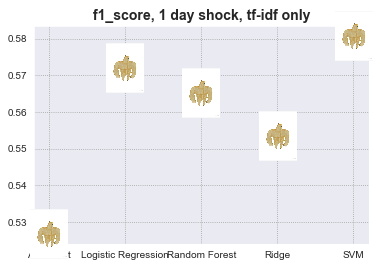

<Figure size 1080x576 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path, zoom=0.05):
    return OffsetImage(plt.imread(path), zoom=zoom)

paths = [
    'dogge.jpg']*5
    

x = ['AdaBoost','Logistic Regression','Random Forest','Ridge','SVM']
y = [0.526837,0.571935,0.565222,0.553573,0.580676]
fig, ax = plt.subplots()
ax.scatter(x, y) 

plt.title('f1_score, 1 day shock, tf-idf only', weight='bold').set_fontsize('14')
plt.figure(figsize=(15,8))
for x0, y0, path in zip(x, y,paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

# создаем таблички

In [17]:
report.to_csv('f1_1_10min.csv')

In [18]:
report_1.to_csv('f1_2_10min.csv')

In [19]:
report_6.to_csv('f1_5_10min_onlynews.csv')

NameError: name 'report_6' is not defined